In [1]:
import librosa
from librosa import display
from librosa import feature

import numpy as np
from numpy import typing as npt

from matplotlib import pyplot as plt
import scipy
import soundfile as sf

In [2]:
y, sr = librosa.load("./Mozart_Turkish_March.wav", duration=25)

In [3]:
def beat_analysis(y: npt.ArrayLike, sr: int, write_to_wav: bool = True, spec_type: str = 'mel', spec_hop_length: int = 512) :
    
    fig, ax = plt.subplots(nrows=2, sharex=True)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    times = librosa.times_like(onset_env, sr=sr, hop_length=spec_hop_length)

    if spec_type == 'mel':

        M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=spec_hop_length)
        librosa.display.specshow(librosa.power_to_db(M, ref=np.max), 
                                 y_axis='mel', x_axis='time', hop_length=spec_hop_length,
                                 ax=ax[0])
        ax[0].label_outer()
        ax[0].set(title='Mel spectrogram')
    
    if spec_type == 'stft':

        S = np.abs(librosa.stft(y))
        img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), 
                                       y_axis='log', x_axis='time', ax=ax[0])
        
        ax[0].label_outer()
        ax[0].set_title('Power spectrogram')
        fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
    
    ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    tempoString = 'Tempo = %.2f'% (tempo)
    ax[1].plot([], [], ' ', label = tempoString)
    ax[1].legend()

    if write_to_wav :
        y_beats = librosa.clicks(frames=beats, sr=sr, length=len(y))
        sf.write('stereo_file.wav', y+y_beats, sr, subtype='PCM_24')

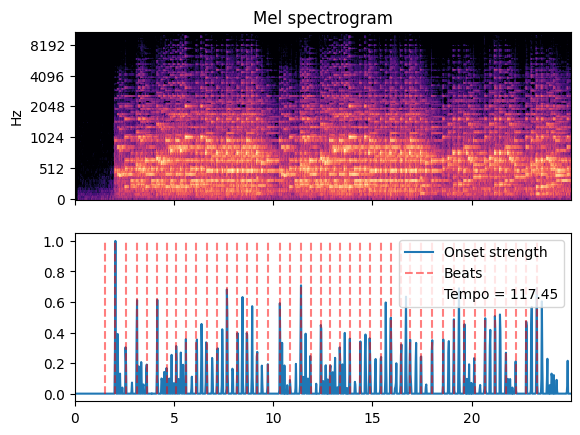

In [4]:
beat_analysis(y, sr)

In [ ]:
def onsets_detection(y: npt.ArrayLike, sr: int, write_to_wav: bool = True) -> None :

    o_env = librosa.onset.onset_strength(y=y, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
    D = np.abs(librosa.stft(y))

    fig, ax = plt.subplots(nrows=2, sharex=True)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                             x_axis='time', y_axis='log', ax=ax[0])
    ax[0].set(title='Power spectrogram')
    ax[0].label_outer()
    ax[1].plot(times, o_env, label='Onset strength')
    ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
                 linestyle='--', label='Onsets')
    ax[1].legend()


    if write_to_wav :
        y_onset_clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(y))
        sf.write('withOnsets.wav', y+y_onset_clicks, sr, subtype='PCM_24')

In [ ]:
def beats_clicks(y: npt.ArrayLike, sr: int) -> None :

    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    y_beats = librosa.clicks(frames=beats, sr=sr, length=len(y))

    sf.write('stereo_file.wav', y+y_beats, sr, subtype='PCM_24')

In [9]:
def predominant_local_pulse(y: npt.ArrayLike, sr:int) -> None :

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
    beats_plp = np.flatnonzero(librosa.util.localmax(pulse))
    times = librosa.times_like(pulse, sr=sr)

    plt.figure()
    plt.plot(times, librosa.util.normalize(pulse),label='PLP')
    plt.vlines(times[beats_plp], 0, 1, alpha=0.5, color='r', 
             linestyle='--', label='PLP Beats')
    plt.legend()
    plt.title("Predominant local pulse")
    



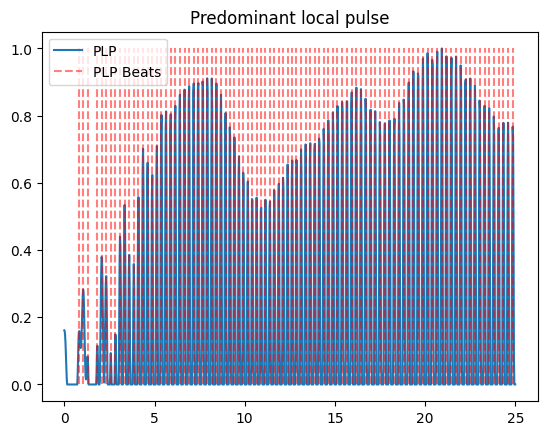

In [10]:
predominant_local_pulse(y, sr)

In [13]:
def static_tempo_estimation(y: npt.ArrayLike, sr: int, hop_length: int = 512) -> None:
  
  '''
  To visualize the result of static tempo estimation
  
  y: input signal array
  sr: sampling rate
  
  '''

  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

  # Static tempo estimation
  prior = scipy.stats.uniform(30, 300)  # uniform over 30-300 BPM
  utempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, prior=prior)

  tempo = tempo.item()
  utempo = utempo.item()
  ac = librosa.autocorrelate(onset_env, max_size=2 * sr // hop_length)
  freqs = librosa.tempo_frequencies(len(ac), sr=sr,
                                   hop_length=hop_length)

  fig, ax = plt.subplots()
  ax.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
              label='Onset autocorrelation', base=2)
  ax.axvline(tempo, 0, 1, alpha=0.75, linestyle='--', color='r',
             label='Tempo (default prior): {:.2f} BPM'.format(tempo))    
  ax.axvline(utempo, 0, 1, alpha=0.75, linestyle=':', color='g',
             label='Tempo (uniform prior): {:.2f} BPM'.format(utempo)) 
  ax.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
  ax.grid(True)
  ax.legend() 

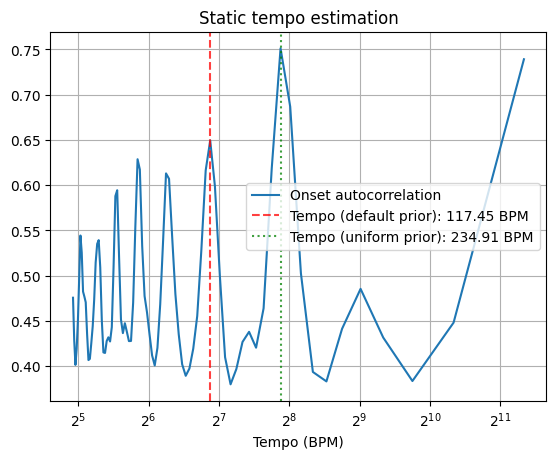

In [14]:
static_tempo_estimation(y, sr)

In [17]:
def plot_tempogram(y: npt.ArrayLike, sr: int, type: str = 'autocorr', hop_length: int = 512) -> None :
    
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]

    if type == 'fourier' :
        # To determine which temp to show?
        librosa.display.specshow(np.abs(tempogram), sr=sr, hop_length=hop_length, 
                                 x_axis='time', y_axis='fourier_tempo', cmap='magma')
        plt.axhline(tempo, color='w', linestyle='--', alpha=1, label='Estimated tempo={:g}'.format(tempo))
        plt.legend(loc='upper right')
        plt.title('Fourier Tempogram')

    if type == 'autocorr' :
        ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length, norm=None)
        librosa.display.specshow(ac_tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo', cmap='magma')
        plt.axhline(tempo, color='w', linestyle='--', alpha=1, label='Estimated tempo={:g}'.format(tempo))
        plt.legend(loc='upper right')
        plt.title('Autocorrelation Tempogram')


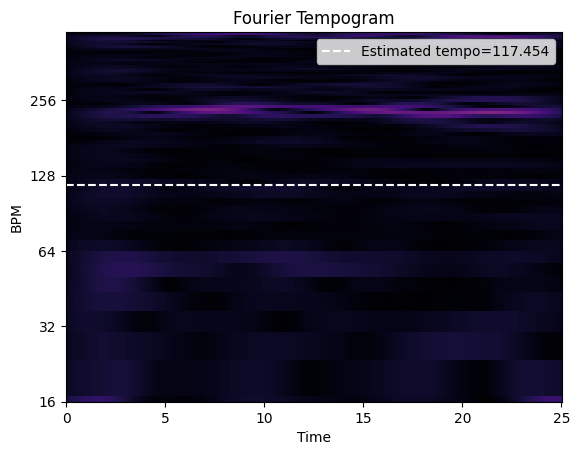

In [18]:
plot_tempogram(y, sr, type= 'fourier')

In [8]:
def plot_onset_strength(y: npt.ArrayLike, sr:int, standard: bool = True, custom_mel: bool = False, cqt: bool = False) -> None :
    
    D = np.abs(librosa.stft(y))
    times = librosa.times_like(D)

    fig, ax = plt.subplots(nrows=2, sharex=True)
    librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax[0])
    
    ax[0].set(title='Power spectrogram')
    ax[0].label_outer()

    # Standard Onset Fuction 

    if standard :
        onset_env_standard = librosa.onset.onset_strength(y=y, sr=sr)
        ax[1].plot(times, 2 + onset_env_standard / onset_env_standard.max(), alpha=0.8, label='Mean (mel)')
    
    if custom_mel :
        onset_env_mel = librosa.onset.onset_strength(y=y, sr=sr,
                                                     aggregate=np.median,
                                                     fmax=8000, n_mels=256)
        ax[1].plot(times, 1 + onset_env_mel / onset_env_mel.max(), alpha=0.8, label='Median (custom mel)')
    
    if cqt :
        C = np.abs(librosa.cqt(y=y, sr=sr))
        onset_env_cqt = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
        ax[1].plot(times, onset_env_cqt / onset_env_cqt.max(), alpha=0.8, label='Mean (CQT)')

    ax[1].legend()
    ax[1].set(ylabel='Normalized strength', yticks=[])

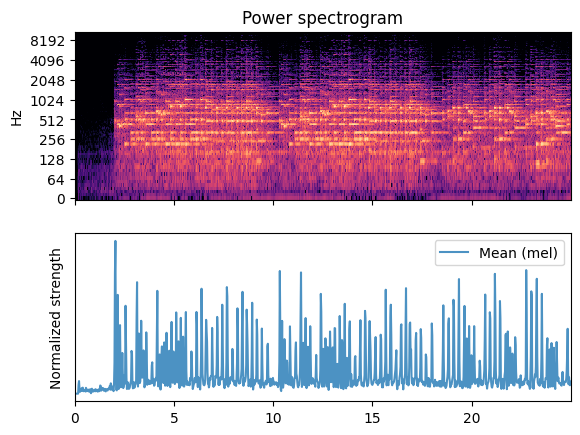

In [9]:
plot_onset_strength(y, sr)

In [4]:
def onset_and_beat_analysis(y: npt.ArrayLike, sr:int, show_tempo: bool = True, spec_type: str = 'mel', spec_hop_length: int = 512, save_to_csv: bool =True) -> None :
    
    fig, ax = plt.subplots(nrows=2, sharex=True)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    times = librosa.times_like(onset_env, sr=sr, hop_length=spec_hop_length)

    if spec_type == 'mel':

        M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=spec_hop_length)
        librosa.display.specshow(librosa.power_to_db(M, ref=np.max), 
                                 y_axis='mel', x_axis='time', hop_length=spec_hop_length,
                                 ax=ax[0])
        ax[0].label_outer()
        ax[0].set(title='Mel spectrogram')
    
    if spec_type == 'stft':

        S = np.abs(librosa.stft(y))
        img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), 
                                       y_axis='log', x_axis='time', ax=ax[0])
        
        ax[0].label_outer()
        ax[0].set_title('Power spectrogram')
        fig.colorbar(img, ax=ax[0], format="%+2.0f dB")
    
    ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    
    if show_tempo :
        tempoString = 'Tempo = %.2f'% (tempo)
        ax[1].plot([], [], ' ', label = tempoString)
    
    ax[1].legend()

    if save_to_csv :
        np.savetxt('onset_times.csv', times.T, fmt="%.3f")
        np.savetxt('beat_time.csv', times[beats].T, fmt="%.3f")




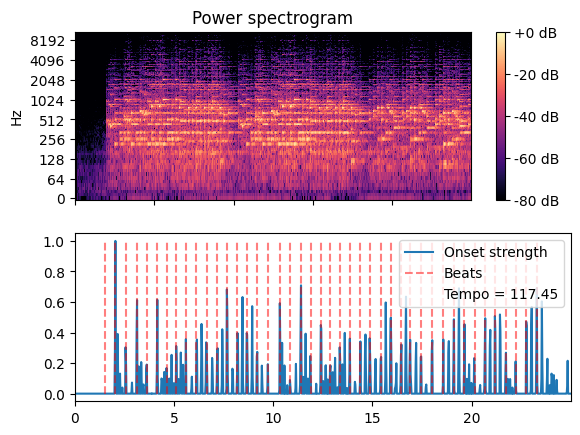

In [5]:
onset_and_beat_analysis(y, sr, spec_type='stft')